In [1]:
!wget https://s3.ap-south-1.amazonaws.com/discovery-nlp-data/embd.dat
!wget https://s3.ap-south-1.amazonaws.com/discovery-nlp-data/dataset.csv

--2018-06-11 11:44:44--  https://s3.ap-south-1.amazonaws.com/discovery-nlp-data/embd.dat
Resolving s3.ap-south-1.amazonaws.com (s3.ap-south-1.amazonaws.com)... 52.219.64.45
Connecting to s3.ap-south-1.amazonaws.com (s3.ap-south-1.amazonaws.com)|52.219.64.45|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 8762536 (8.4M) [binary/octet-stream]
Saving to: ‘embd.dat’

embd.dat            100%[===================>]   8.36M   929KB/s    in 33s     

2018-06-11 11:45:18 (259 KB/s) - ‘embd.dat’ saved [8762536/8762536]

--2018-06-11 11:45:19--  https://s3.ap-south-1.amazonaws.com/discovery-nlp-data/dataset.csv
Resolving s3.ap-south-1.amazonaws.com (s3.ap-south-1.amazonaws.com)... 52.219.64.17
Connecting to s3.ap-south-1.amazonaws.com (s3.ap-south-1.amazonaws.com)|52.219.64.17|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170631 (167K) [text/csv]
Saving to: ‘dataset.csv’

dataset.csv         100%[===================>] 166.63K  40.1KB/s    in 4

In [0]:
import pandas as pd
import numpy as np
import re
df = pd.read_csv('dataset.csv',sep=",",header=None ,names=['sentence','type'])

embedding_matrix=np.load("embd.dat")

In [3]:
Y = df['type']
from sklearn import preprocessing
from keras.utils.np_utils import to_categorical

le = preprocessing.LabelEncoder()
le.fit(Y)
Y=le.transform(Y) 
labels = to_categorical(np.asarray(Y))

Using TensorFlow backend.


In [0]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
# from unidecode import unidecode
# fit_on_texts(textdata))
MAX_NB_WORDS = 16384
MAX_SEQUENCE_LENGTH=128


In [6]:
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, split=' ')

alist=[str(x) for x in df['sentence'].values ]
tokenizer.fit_on_texts(alist)
X=tokenizer.texts_to_sequences(alist)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)


word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, labels, test_size = 0.2)


Found 3650 unique tokens.


In [0]:
# embeddings_index = {}

# f = open('/home/yash/glove.42B.300d.txt')
# for line in f:
#     #print line
#     values = line.split()
#     word = values[0]
#     coefs = np.asarray(values[1:], dtype='float32')
#     embeddings_index[word] = coefs
# f.close()

# print('Found %s word vectors.' % len(embeddings_index))


# word_index = tokenizer.word_index
# print('Found %s unique tokens.' % len(word_index))

# emb_dimension=300
# embedding_matrix = np.zeros((len(word_index) + 1, emb_dimension))
# for word, i in word_index.items():
#     embedding_vector = embeddings_index.get(word)
#     if embedding_vector is not None:
#         # words not found in embedding index will be all-zeros.
#         embedding_matrix[i] = embedding_vector
        
# embedding_matrix.dump('embd.dat')

Found 1917494 word vectors.
Found 3650 unique tokens.


In [19]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding
from keras.callbacks import History ,ReduceLROnPlateau
from keras import regularizers
from keras import optimizers
history = History()
model = Sequential()
model.add(Embedding(len(word_index)+1,
                            300,
                            weights=[embedding_matrix],
                            input_length=MAX_SEQUENCE_LENGTH,
                            trainable=False))

model.add(LSTM(256,
               return_sequences=True, 
               dropout=0.5, 
               recurrent_dropout=0.5, 
               activation='relu',
               kernel_regularizer=regularizers.l2(0.001))), 
               # activity_regularizer=regularizers.l1(0.01)))

model.add(LSTM(128, 
               dropout=0.4,
               #return_sequences=True,
               recurrent_dropout=0.4, 
               activation='relu',
               kernel_regularizer=regularizers.l2(0.001)))

#model.add(LSTM(256, dropout_U=0.5, dropout_W=0.5, activation='relu', kernel_regularizer=l2_reg))
model.add(Dense(4,activation='softmax'))#,kernel_regularizer=regularizers.l2(0.01), activity_regularizer=regularizers.l1(0.01)))
rmsprop = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)
model.compile(loss = 'categorical_crossentropy', optimizer=rmsprop,metrics = ['accuracy'])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 128, 300)          1095300   
_________________________________________________________________
lstm_11 (LSTM)               (None, 128, 256)          570368    
_________________________________________________________________
lstm_12 (LSTM)               (None, 128)               197120    
_________________________________________________________________
dense_6 (Dense)              (None, 4)                 516       
Total params: 1,863,304
Trainable params: 768,004
Non-trainable params: 1,095,300
_________________________________________________________________


In [22]:

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1,patience=5, min_lr=0.0001, cooldown=5)
history=model.fit(x_train, y_train,
          batch_size=1575,
          epochs=200,
          verbose=1,
          callbacks=[reduce_lr],
          validation_data=(x_test, y_test))

Train on 1575 samples, validate on 394 samples
Epoch 1/200
1575/1575 [==============================] - 2s 1ms/step - loss: 1.5378 - acc: 0.5530 - val_loss: 1.4967 - val_acc: 0.6269
Epoch 2/200
1575/1575 [==============================] - 2s 984us/step - loss: 1.5200 - acc: 0.5721 - val_loss: 1.4574 - val_acc: 0.6345
Epoch 3/200
1575/1575 [==============================] - 2s 994us/step - loss: 1.5095 - acc: 0.5771 - val_loss: 1.4209 - val_acc: 0.6675
Epoch 4/200
1575/1575 [==============================] - 2s 984us/step - loss: 1.4652 - acc: 0.6019 - val_loss: 1.3860 - val_acc: 0.6777
Epoch 5/200
1575/1575 [==============================] - 2s 995us/step - loss: 1.4294 - acc: 0.6362 - val_loss: 1.3562 - val_acc: 0.6802
Epoch 6/200
1575/1575 [==============================] - 2s 985us/step - loss: 1.4078 - acc: 0.6260 - val_loss: 1.3268 - val_acc: 0.6751
Epoch 7/200
1575/1575 [==============================] - 2s 990us/step - loss: 1.3578 - acc: 0.6349 - val_loss: 1.2943 - val_acc: 0.6

1575/1575 [==============================] - 2s 992us/step - loss: 1.0590 - acc: 0.7130 - val_loss: 1.0003 - val_acc: 0.7462
Epoch 28/200
1575/1575 [==============================] - 2s 986us/step - loss: 1.0484 - acc: 0.7225 - val_loss: 0.9920 - val_acc: 0.7437
Epoch 29/200
1575/1575 [==============================] - 2s 997us/step - loss: 1.0295 - acc: 0.7168 - val_loss: 0.9876 - val_acc: 0.7538
Epoch 30/200
1575/1575 [==============================] - 2s 981us/step - loss: 0.9999 - acc: 0.7244 - val_loss: 1.0012 - val_acc: 0.7563
Epoch 31/200
1575/1575 [==============================] - 2s 991us/step - loss: 1.0159 - acc: 0.7257 - val_loss: 0.9949 - val_acc: 0.7513
Epoch 32/200
1575/1575 [==============================] - 2s 989us/step - loss: 0.9993 - acc: 0.7206 - val_loss: 0.9822 - val_acc: 0.7513
Epoch 33/200
1575/1575 [==============================] - 2s 993us/step - loss: 1.0109 - acc: 0.7314 - val_loss: 1.0054 - val_acc: 0.7487
Epoch 34/200
1575/1575 [=======================

1575/1575 [==============================] - 2s 989us/step - loss: 1.0302 - acc: 0.7276 - val_loss: 0.9333 - val_acc: 0.7589
Epoch 54/200
1575/1575 [==============================] - 2s 992us/step - loss: 1.0232 - acc: 0.7194 - val_loss: 0.9329 - val_acc: 0.7563
Epoch 55/200
1575/1575 [==============================] - 2s 998us/step - loss: 1.0050 - acc: 0.7340 - val_loss: 0.9323 - val_acc: 0.7563
Epoch 56/200
1575/1575 [==============================] - 2s 987us/step - loss: 0.9911 - acc: 0.7403 - val_loss: 0.9317 - val_acc: 0.7563
Epoch 57/200
1575/1575 [==============================] - 2s 993us/step - loss: 0.9743 - acc: 0.7340 - val_loss: 0.9312 - val_acc: 0.7589
Epoch 58/200
1575/1575 [==============================] - 2s 985us/step - loss: 1.0212 - acc: 0.7225 - val_loss: 0.9308 - val_acc: 0.7614
Epoch 59/200
1575/1575 [==============================] - 2s 992us/step - loss: 1.0209 - acc: 0.7340 - val_loss: 0.9304 - val_acc: 0.7614
Epoch 60/200
1575/1575 [=======================

1575/1575 [==============================] - 2s 989us/step - loss: 1.1382 - acc: 0.7143 - val_loss: 0.9455 - val_acc: 0.7360
Epoch 80/200
1575/1575 [==============================] - 2s 992us/step - loss: 1.0828 - acc: 0.7321 - val_loss: 0.9445 - val_acc: 0.7360
Epoch 81/200
1575/1575 [==============================] - 2s 992us/step - loss: 1.0953 - acc: 0.7302 - val_loss: 0.9436 - val_acc: 0.7360
Epoch 82/200
1575/1575 [==============================] - 2s 988us/step - loss: 1.0958 - acc: 0.7333 - val_loss: 0.9428 - val_acc: 0.7386
Epoch 83/200
1575/1575 [==============================] - 2s 993us/step - loss: 1.1148 - acc: 0.7079 - val_loss: 0.9420 - val_acc: 0.7437
Epoch 84/200
1575/1575 [==============================] - 2s 988us/step - loss: 1.0713 - acc: 0.7289 - val_loss: 0.9412 - val_acc: 0.7462
Epoch 85/200
1575/1575 [==============================] - 2s 991us/step - loss: 1.0664 - acc: 0.7219 - val_loss: 0.9404 - val_acc: 0.7487
Epoch 86/200
1575/1575 [=======================

1575/1575 [==============================] - 2s 989us/step - loss: 1.0671 - acc: 0.7263 - val_loss: 0.9394 - val_acc: 0.7487
Epoch 106/200
1575/1575 [==============================] - 2s 991us/step - loss: 1.0257 - acc: 0.7302 - val_loss: 0.9400 - val_acc: 0.7437
Epoch 107/200
1575/1575 [==============================] - 2s 989us/step - loss: 1.0203 - acc: 0.7371 - val_loss: 0.9406 - val_acc: 0.7437
Epoch 108/200
1575/1575 [==============================] - 2s 988us/step - loss: 1.0322 - acc: 0.7244 - val_loss: 0.9411 - val_acc: 0.7437
Epoch 109/200
1575/1575 [==============================] - 2s 989us/step - loss: 1.0989 - acc: 0.7390 - val_loss: 0.9415 - val_acc: 0.7411
Epoch 110/200
1575/1575 [==============================] - 2s 987us/step - loss: 1.0376 - acc: 0.7314 - val_loss: 0.9419 - val_acc: 0.7411
Epoch 111/200
1575/1575 [==============================] - 2s 993us/step - loss: 1.0272 - acc: 0.7340 - val_loss: 0.9423 - val_acc: 0.7411
Epoch 112/200
1575/1575 [================

1575/1575 [==============================] - 2s 987us/step - loss: 1.1105 - acc: 0.7257 - val_loss: 0.9483 - val_acc: 0.7335
Epoch 132/200
1575/1575 [==============================] - 2s 992us/step - loss: 1.0576 - acc: 0.7244 - val_loss: 0.9484 - val_acc: 0.7335
Epoch 133/200
1575/1575 [==============================] - 2s 992us/step - loss: 1.0901 - acc: 0.7156 - val_loss: 0.9484 - val_acc: 0.7335
Epoch 134/200
1575/1575 [==============================] - 2s 987us/step - loss: 1.0757 - acc: 0.7238 - val_loss: 0.9484 - val_acc: 0.7335
Epoch 135/200
1575/1575 [==============================] - 2s 990us/step - loss: 1.0810 - acc: 0.7340 - val_loss: 0.9483 - val_acc: 0.7335
Epoch 136/200
1575/1575 [==============================] - 2s 989us/step - loss: 1.0972 - acc: 0.7194 - val_loss: 0.9482 - val_acc: 0.7360
Epoch 137/200
1575/1575 [==============================] - 2s 994us/step - loss: 1.0984 - acc: 0.7333 - val_loss: 0.9481 - val_acc: 0.7386
Epoch 138/200
1575/1575 [================

1575/1575 [==============================] - 2s 987us/step - loss: 1.1010 - acc: 0.7314 - val_loss: 0.9353 - val_acc: 0.7538
Epoch 158/200
1575/1575 [==============================] - 2s 991us/step - loss: 1.0928 - acc: 0.7340 - val_loss: 0.9332 - val_acc: 0.7513
Epoch 159/200
1575/1575 [==============================] - 2s 988us/step - loss: 1.1038 - acc: 0.7244 - val_loss: 0.9319 - val_acc: 0.7538
Epoch 160/200
1575/1575 [==============================] - 2s 989us/step - loss: 1.0303 - acc: 0.7219 - val_loss: 0.9311 - val_acc: 0.7640
Epoch 161/200
1575/1575 [==============================] - 2s 989us/step - loss: 1.0514 - acc: 0.7333 - val_loss: 0.9309 - val_acc: 0.7640
Epoch 162/200
1575/1575 [==============================] - 2s 987us/step - loss: 1.0293 - acc: 0.7505 - val_loss: 0.9308 - val_acc: 0.7640
Epoch 163/200
1575/1575 [==============================] - 2s 990us/step - loss: 0.9911 - acc: 0.7365 - val_loss: 0.9309 - val_acc: 0.7665
Epoch 164/200
1575/1575 [================

1575/1575 [==============================] - 2s 987us/step - loss: 1.0079 - acc: 0.7327 - val_loss: 0.9383 - val_acc: 0.7868
Epoch 184/200
1575/1575 [==============================] - 2s 996us/step - loss: 0.9764 - acc: 0.7340 - val_loss: 0.9384 - val_acc: 0.7868
Epoch 185/200
1575/1575 [==============================] - 2s 988us/step - loss: 0.9972 - acc: 0.7371 - val_loss: 0.9386 - val_acc: 0.7868
Epoch 186/200
1575/1575 [==============================] - 2s 996us/step - loss: 1.0392 - acc: 0.7276 - val_loss: 0.9387 - val_acc: 0.7868
Epoch 187/200
1575/1575 [==============================] - 2s 991us/step - loss: 1.0259 - acc: 0.7295 - val_loss: 0.9388 - val_acc: 0.7868
Epoch 188/200
1575/1575 [==============================] - 2s 990us/step - loss: 1.0553 - acc: 0.7244 - val_loss: 0.9389 - val_acc: 0.7868
Epoch 189/200
1575/1575 [==============================] - 2s 993us/step - loss: 1.0132 - acc: 0.7410 - val_loss: 0.9389 - val_acc: 0.7868
Epoch 190/200
1575/1575 [================

In [0]:
example = tokenizer.texts_to_sequences(["food was worse"])
example = pad_sequences(example, maxlen=MAX_SEQUENCE_LENGTH)
print model.predict(example),type(model.predict(example))
le.inverse_transform(np.argmax(model.predict(example)))

[[0.6241612  0.17492281 0.08832416 0.11259187]] <type 'numpy.ndarray'>


/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


'FB'

In [9]:
# evaluate the model of test data

from sklearn.metrics import classification_report
predictions = model.predict(x_test)
#print(classification_report(predictions,y_test))
print("Accuracy :",model.evaluate(x_test,y_test))

394/394 [==============================] - 2s 6ms/step
('Accuracy :', [1.8976286564986717, 0.6319796948263487])


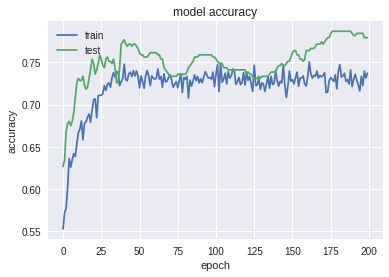

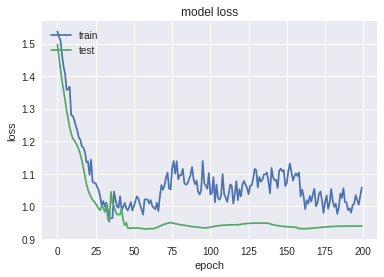

In [23]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()